# 규제 선형 모델

- 다항식이 복잡해지면서 회귀 계수값이 크게 설정되고 과대 적합을 유발함
    -> 훈련 데이터에서는 높은 성능을 보이지만, 테스트 데이터에서는 낮은 성능을 보임

- 선형 모델의 목적은 비용 함수를 최소화하는 것
- 이때, 규제 선형 모델은 비용 함수를 최소화하는 데에 패널티(alpha)를 적용해 회귀 계수의 크기를 제한함


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Ridge 회귀
- L2 규제를 적용한 회귀 모델
- 회귀 계수들의 제곱합에 alpha 패널티를 곱해 비용 산정에 반영
- alpha 값이 커지면 회귀 계수가 작아짐 -> 과대적합 방지

In [4]:
from sklearn.model_selection import train_test_split

boston_df = pd.read_csv('./data/boston_housing_train.csv')

X = boston_df.drop('MEDV', axis=1)
y = boston_df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=10) # model 객체 생성
reg.fit(X_train, y_train) # 훈련
print(reg.score(X_train, y_train), reg.score(X_test, y_test)) # 평가

print(reg.coef_)
print(reg.intercept_)

# 단순 회귀 성능 검사 시 과대적합이 나왔을 때: 성능을 평가한 지표 자체는 좋아졌지만 과적합 현상이 있었음

0.7398240895568371 0.6724237562438147
[-0.12137453  0.03421897 -0.01307037  1.8210257  -1.68747299  4.09010212
 -0.01841796 -1.18806788  0.24351944 -0.01208251 -0.76717881  0.01369631
 -0.5734354 ]
22.652200585179877


In [6]:
reg.alpha # alpha값의 기본값은 1이고, 이걸 바꿔주는 방법은 reg 객체 만들 떄 alpha라고 하는 매개변수를 넣으면 됨
# alpha가 크면: 모델이 더 많이 규제되어 회귀 계수(가중치)가 더 작은 값으로 수렴
# alpha가 작으면: 정규화가 더 적게 적용되어 모델이 훈련 데이터셋에 잘 맞으나 과적합 우려가 있음


10

In [8]:
# 다른 평가 지표
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')

In [ ]:
from sklearn.pipeline import Pipeline # Pipeline: 모델을 순차적으로 연결하여 하나의 객체로 만들 수 있는 도구
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, degree=2)),
    # alpha가 커질수록 규제가 심해지는거라 평가지표가 떨어지게 됨, alpha가 작을수록 훈련 데이터셋에 맞게 적용되어 평가지표가 올라감
    # ❓ 그럼 alpha값은 보통 얼마를 주는걸까 ❓
    ('reg', Ridge(alpha=10)) # 규제 강도(alpha)가 높아질수록 과대적합에 강해짐
])

model.fit(X_train, y_train)
print(model.score(X_train, y_train), model.score(X_test, y_test))
evaluate_regression(y_test, model.predict(X_test))

0.934045449915728 0.7735821268700346
MSE: 15.855396927570286, RMSE: 3.981883590409228, MAE: 2.490640641202681, R2: 0.7735821268700346


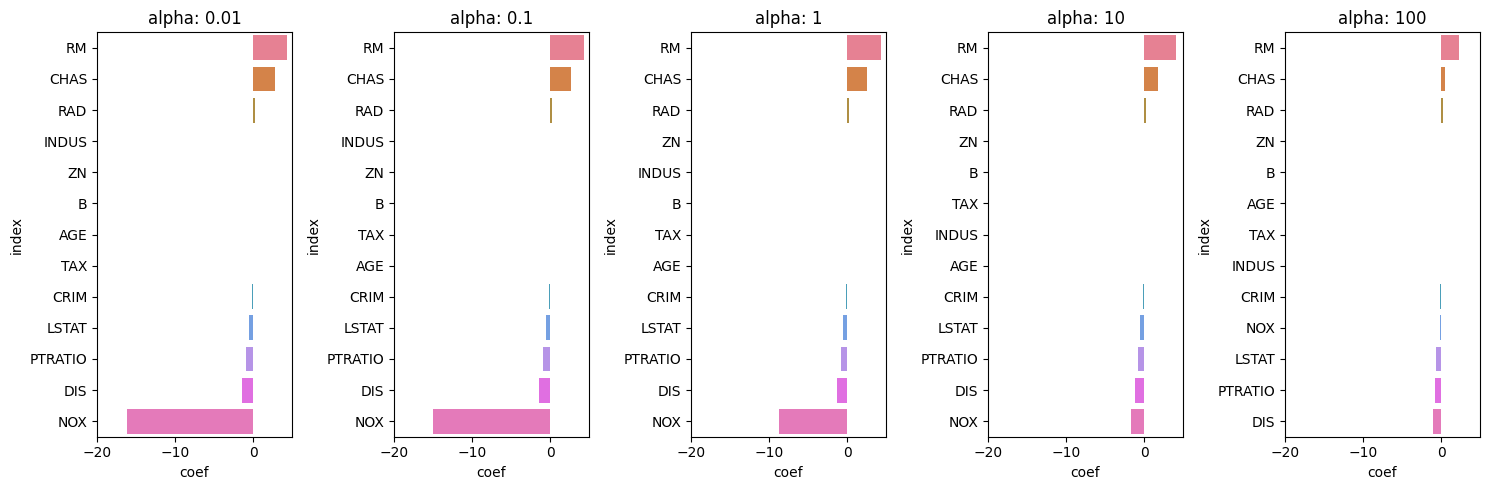

In [ ]:
# alpha 값에 따른 시각화
# alpha 값이 커질수록 회귀 계수가 점점 작아지는 것을 눈으로 볼 수 있음
# 규제가 강해질수록 회귀 계수가 작아지는 것을 시각화

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

alphas = [0.01, 0.1, 1, 10, 100]

for i, alpha in enumerate(alphas):
    model = Pipeline([
        # ('poly', PolynomialFeatures(include_bias=False, degree=2)), # 차수를 증가시켜줘서 길이가 안맞다는 에러가 나와서 주석처리함
        # ❓ poly를 주석처리하면 꼭 pipeline으로 안써도되는거져 ❓
        ('reg', Ridge(alpha=alpha))
    ])

    model.fit(X_train, y_train) # 훈련

    coef = model.named_steps['reg'].coef_ # 회귀 계수
    coef_ser = pd.Series(coef, index=X.columns) # 가중치로 series 만들기
    coef_ser.name = 'alpha: ' + str(alpha)
    coef_ser = coef_ser.sort_values(ascending=False) # 기준치를 중심으로 값을 정렬

    ax[i].set_title(coef_ser.name)
    ax[i].set_xlabel('coef')
    ax[i].set_ylabel('index')
    ax[i].set_xlim(-20,5) # coef에 대한 범위가 안맞춰져 있어서 시각화가 극적으로 보이지 않아서 맞춰주는 것임
    sns.barplot(x=coef_ser.values, y=coef_ser.index, ax=ax[i], hue=coef_ser.index)


plt.tight_layout()
plt.show()

---

### Lasso 회귀
- L1 규제를 적용한 선형 회귀 모델
- 회귀 계수 절대값의 합을 alpha 값과 곱해 규제 정도를 지정
- alpha 값이 커지면 규제 정도가 커짐
- 회귀 계수를 0까지 줄일 수 있음 = 해당 특성을 아예 반영하지 않아도 됨 = 특성 선택 효과가 있음

In [ ]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=10)

reg.fit(X_train, y_train)

print(reg.score(X_train, y_train), reg.score(X_test, y_test))
print(reg.coef_)

# 규제를 하지 않은 다항회귀 평가
# 0.945... 0.776...
# alpha를 높이면: 규제를 엄격히 한다고 해서 과대적합이 해결되는 것도 아님
# bc. 회귀 계수가 0이 된 것이 많은데 특성들을 반영하지 못했기 때문임
# alpha에 대한 값이 커지면 규제 정도가 심해지고, 회귀 계수가 0이 되어서 해당 특성을 반영하지 않아 버리는 결과가 나올 수도 있어서 조심해야 함

0.5373948270602298 0.49459972513091244
[-0.          0.00806625 -0.          0.          0.          0.
  0.         -0.          0.         -0.00896833 -0.          0.01014021
 -0.62986968]


---

### ElasticNet 회귀
- L1, L2 규제를 함께 적용할 수 있는 회귀 모델

**하이퍼 파라미터**
- alpha: 규제정도 (L1 + L2)
- l1_ratio: alpha 값 중 L1 규제의 비율

In [ ]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet(alpha=10, l1_ratio=0.2) # reg.alpha 기본값: 1, reg.l1_ratio 기본값: 0.5, L2 + L1 = alpha -> L2 + 0.5 = 1 -> L2 = 0.5

reg.fit(X_train, y_train)

print(reg.score(X_train, y_train), reg.score(X_test, y_test))
print(reg.coef_)

0.6914758177681419 0.6584782663638298
[-0.11304195  0.03616532 -0.02567739  0.01331622 -0.          1.08071656
  0.01537004 -0.76232832  0.28676237 -0.01396857 -0.76004478  0.01203943
 -0.78366959]


In [32]:
model = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, degree=3)),
    ('reg', ElasticNet(alpha=10, l1_ratio=0.6))
])

model.fit(X_train, y_train)
print(model.score(X_train, y_train), model.score(X_test, y_test))
evaluate_regression(y_test, model.predict(X_test))

0.9575858638993846 0.7398730490075454
MSE: 18.215947365500373, RMSE: 4.2680144523537376, MAE: 2.6511018954793215, R2: 0.7398730490075454


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.218e+02, tolerance: 3.361e+00
  model = cd_fast.enet_coordinate_descent(
